In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import copy
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
# Transforms the data into similar inputs
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
}

In [7]:
# Loading the dataset
data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(root=data_dir, transform=data_transforms[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [8]:
# Split the dataset for training, validation and testing
dataset_size = len(image_datasets['train'])
val_size = int(0.15 * dataset_size)
test_size = int(0.15 * dataset_size)
train_size = dataset_size - val_size - test_size 

train_dataset, val_dataset, test_dataset = random_split(image_datasets['train'], [train_size, val_size, test_size])

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset ,batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset ,batch_size=32, shuffle=False, num_workers=4)
}

dataset_size = {'train': train_size, 'val': val_size, 'test': test_size}



In [129]:
# Function to Visualize the data
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    inp =std * inp + mean
    inp = np.clip(inp,0,1)
    plt.figure(figsize=(50, 50))
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.pause(0.001)

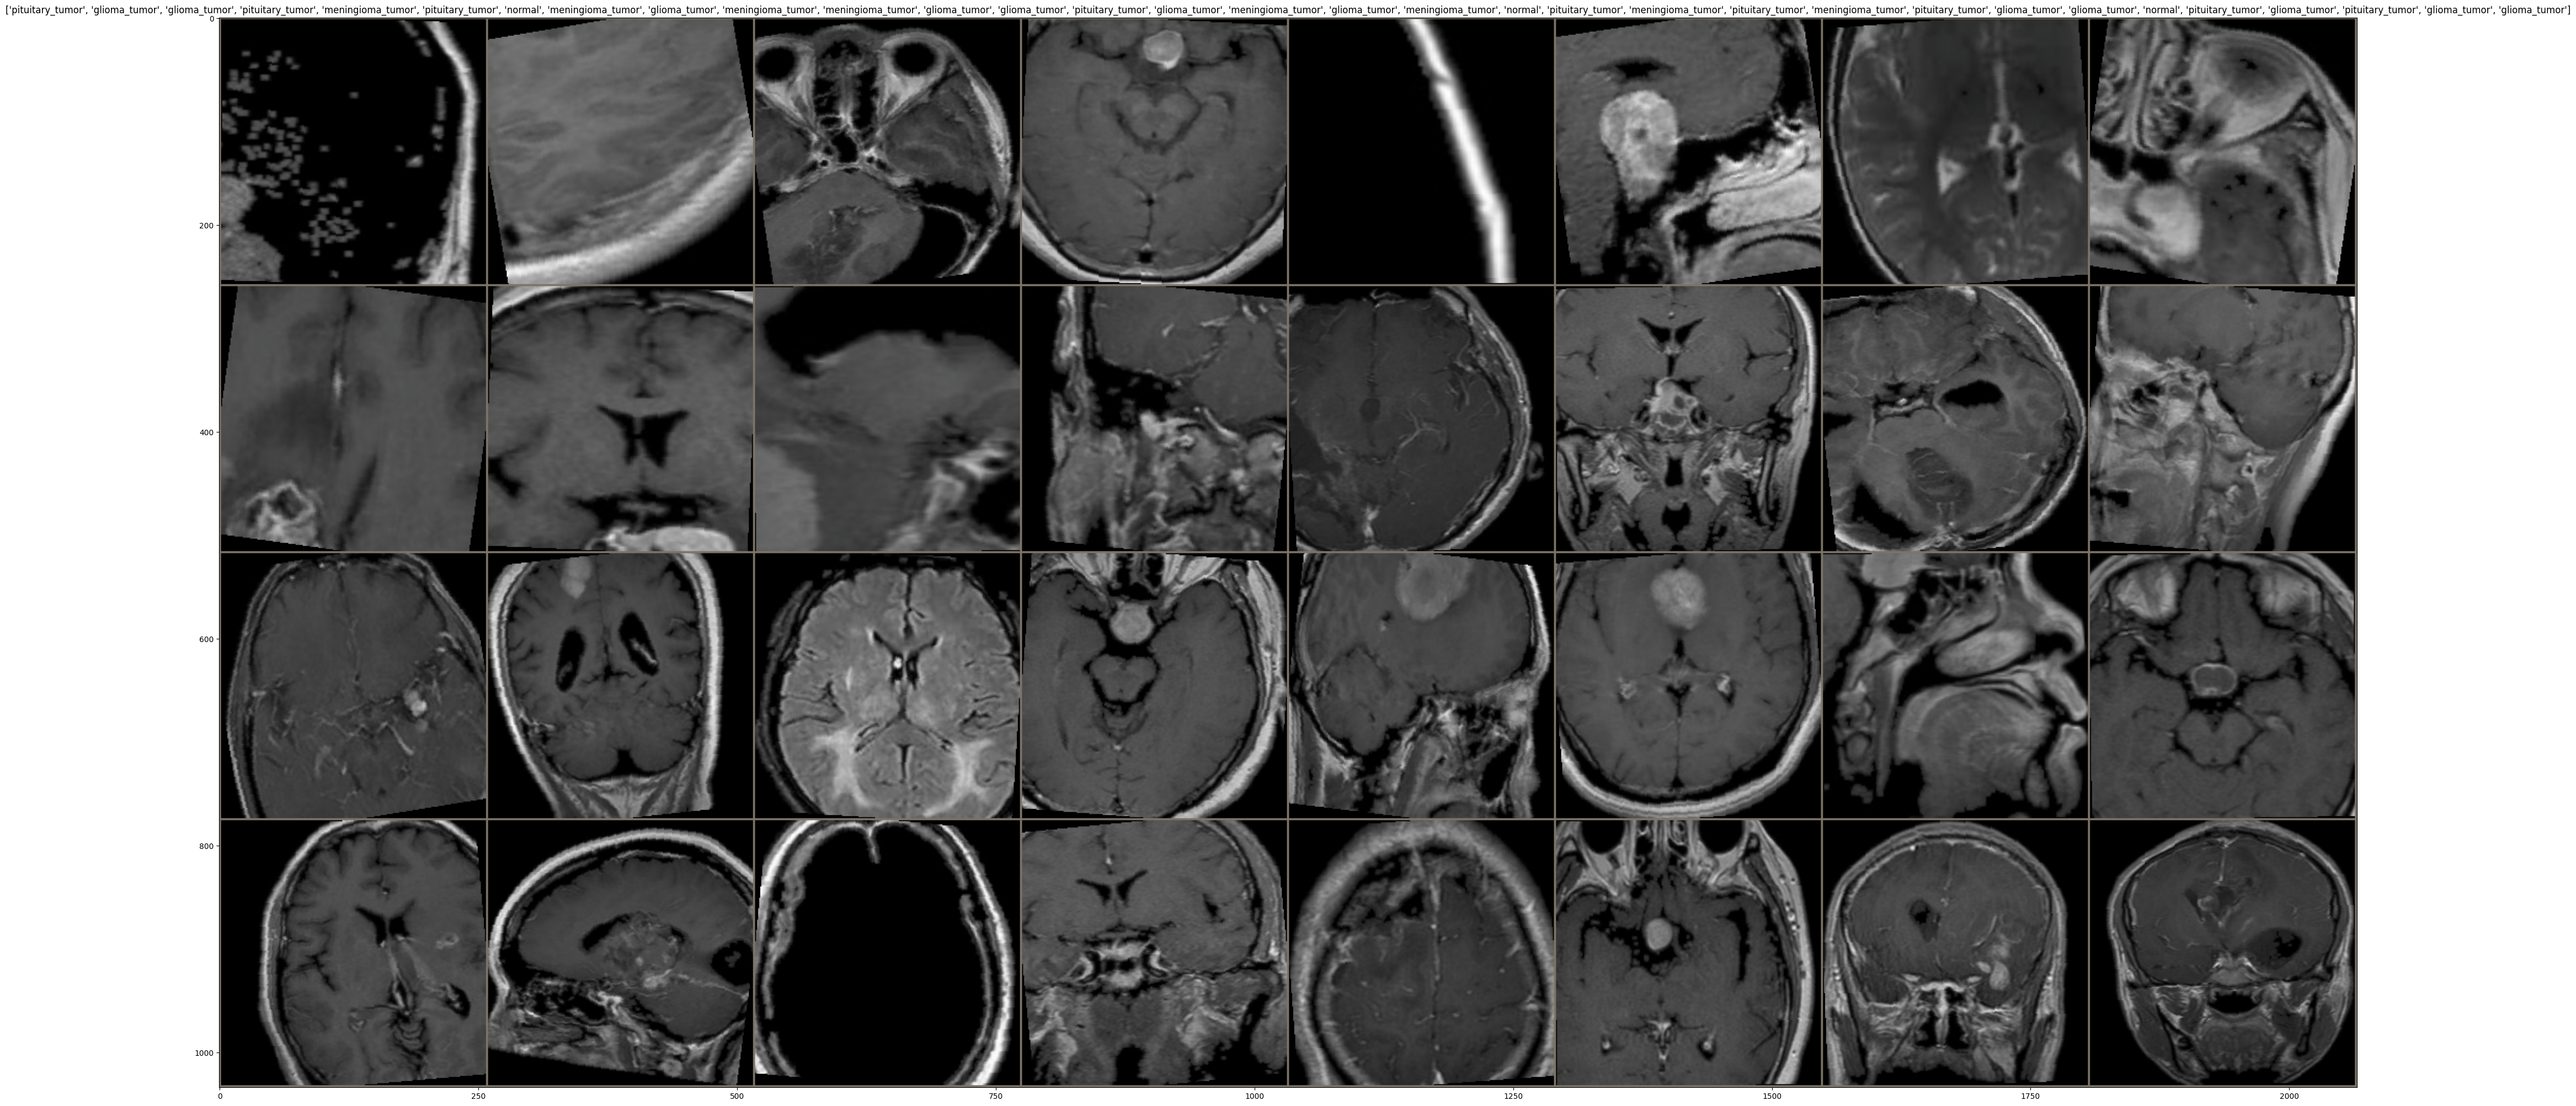

In [130]:
inputs, classes = next(iter(dataloaders['train']))

out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [9]:
# Create a NN class
class MRIModel(nn.Module):
    def __init__(self, num_classes):
        super(MRIModel, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1)
        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Forward pass through convolutional layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # Flatten the tensor
        x = x.view(-1, 128 * 32 * 32)
        # Forward pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [10]:
num_classes = 4
model = MRIModel(num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
# Model is set to use GPU (cuda installed)

MRIModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [11]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [134]:
# THE TRAINING LOOP :)
num_epochs = 1000
best_model_weights = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print("-" * 10)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0 # correct predictions

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs,1)
                loss = criterion(outputs, labels)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_size[phase]
        epoch_acc = running_corrects.double() / dataset_size[phase] # Accuracy of Epoch

        print(f'{phase} Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}')

        # Deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_weights = copy.deepcopy(model.state_dict())
    
    print()

print('\nTraining Complete\n')
print(f'Best Validation Accuracy: {best_acc:4f}')
model.load_state_dict(best_model_weights) # Saving the Model to memory

torch.save(model.state_dict(), 'MRI_Tumor_Detection.pth')
print("Model is saved. The End") # Saves it to file

Epoch 1/1000
----------
train Loss: 1.5746 Accuracy: 0.3436
val Loss: 1.1779 Accuracy: 0.4677

Epoch 2/1000
----------
train Loss: 1.2400 Accuracy: 0.4220
val Loss: 1.1786 Accuracy: 0.4461

Epoch 3/1000
----------
train Loss: 1.2207 Accuracy: 0.4377
val Loss: 1.1643 Accuracy: 0.5086

Epoch 4/1000
----------
train Loss: 1.1703 Accuracy: 0.4557
val Loss: 1.1596 Accuracy: 0.4828

Epoch 5/1000
----------
train Loss: 1.1440 Accuracy: 0.4949
val Loss: 1.1173 Accuracy: 0.5043

Epoch 6/1000
----------
train Loss: 1.0828 Accuracy: 0.5327
val Loss: 1.0253 Accuracy: 0.5647

Epoch 7/1000
----------
train Loss: 1.0386 Accuracy: 0.5484
val Loss: 0.9922 Accuracy: 0.5625

Epoch 8/1000
----------
train Loss: 1.0293 Accuracy: 0.5558
val Loss: 1.0968 Accuracy: 0.4978

Epoch 9/1000
----------
train Loss: 0.9827 Accuracy: 0.5899
val Loss: 1.0331 Accuracy: 0.5668

Epoch 10/1000
----------
train Loss: 0.9753 Accuracy: 0.5923
val Loss: 0.9900 Accuracy: 0.5841

Epoch 11/1000
----------
train Loss: 0.9703 Accur

In [13]:
# Checking the test Accuracy
model = MRIModel(num_classes)
model.load_state_dict(torch.load('MRI_Tumor_Detection.pth'))
model.to(device)
model.eval()
running_corrects = 0
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    running_corrects += torch.sum(preds == labels.data)

test_acc = running_corrects.double() / dataset_size['test']
print(f'Test Accuracy: {test_acc:.4f}')


Test Accuracy: 0.9181


In [24]:
# For confusion Matrix: to judge false positives and false negatives
# & Classification Report: 
all_preds = []
all_labels = []

for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

cr = classification_report(all_labels, all_preds, target_names=image_datasets['train'].classes)
print(cr)

Confusion Matrix:
[[121   6   1   4]
 [ 10 122   5   4]
 [  0   3  48   2]
 [  3   3   2 130]]
                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.92      0.91       132
meningioma_tumor       0.91      0.87      0.89       141
          normal       0.86      0.91      0.88        53
 pituitary_tumor       0.93      0.94      0.94       138

        accuracy                           0.91       464
       macro avg       0.90      0.91      0.90       464
    weighted avg       0.91      0.91      0.91       464



In [17]:
# Reloading the model from the saved file 
# It uses the same class definitions as before as the NN architecture must match
num_classes = 4 
class_names = ['Glioma tumor', 'Meningioma tumor', 'Pituitary tumor', 'Normal']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MRIModel(num_classes)
model.load_state_dict(torch.load('MRI_Tumor_Detection.pth'))
model.to(device)
model.eval()

MRIModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [18]:
transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

img_path = 'G_example_test.jpg'
image = Image.open(img_path)
input_tensor = transform(image)
input_tensor = input_tensor.unsqueeze(0).to(device)

In [19]:
with torch.no_grad():
    outputs = model(input_tensor)

_, predicted = torch.max(outputs, 1)

predicted_class_name = class_names[predicted.item()]
print(f'Predicted class:- \n{predicted_class_name}')
print("\nActual Class:-")
class_names = ['Glioma tumor', 'Meningioma tumor', 'Pituitary tumor', 'Normal']
if img_path[0] == "P":
        print('Pituitary tumor')
if img_path[0] == "M":
        print('Meningioma tumor')
if img_path[0] == "G":
        print('Glioma tumor') 
else: 
    "Normal"   


Predicted class:- 
Glioma tumor

Actual Class:-
Glioma tumor
